## LSTM encoder-decoder with multivariate input (Training using google colab, uploading data from google drive)

In [4]:
# Mounting google drive
from google.colab import drive
drive.mount("/content/google_drive/")

Mounted at /content/google_drive/


In [5]:
# checking if required files are available in my google drive project (I have uploaded my project to google drive)
!ls -R "/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/"

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/':
data  hourly_models  requirements.txt  test_data.csv

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/data':
cleaned_household_power_consumption.csv

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/hourly_models':
eval_scaled_48_to_48.npy       test_scaled_48_to_48.npy
eval_scaled_72_to_48.npy       test_scaled_72_to_48.npy
min_max_all_feat_48_to_48.pkl  train_scaled_48_to_48.npy
min_max_all_feat_72_to_48.pkl  train_scaled_72_to_48.npy
model_4

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/hourly_models/model_4':
weights_best.hdf5


#### All the required data is available. Download the project from [GitHub](https://github.com/Ripunjoy93/individual_household_electric_power_consumption), and saved it to your google drive and follow the above steps.

In [0]:
# change woeking directory to mounted google_drive project directory
import os
google_drive_root = "/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/"
os.chdir(google_drive_root)

#### Installing all requirements files:

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
# installing requirements
!pip install -r requirements.txt

In [8]:
!nvidia-smi

Tue Oct  8 07:14:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
# Check gpu is available or not
# We need to change runtime type if not changed
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != "/device:GPU:0":
    #raise SystemError('GPU device not found')
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Tensorflow version:  1.14.0
/device:GPU:0
Found GPU at: /device:GPU:0


In [10]:
# My local device
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 959664670692676965, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13598656956841584332
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10815189144306302665
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13286909374603703833
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [11]:
# Checking GPU status
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 443.7 MB
GPU RAM Free: 11372MB | Used: 69MB | Util   1% | Total 11441MB


In [0]:
# Test if files are being saved in google drive
import pandas as pd
df = pd.DataFrame({"a":[1,2,3], "b":[4,5,6]})
df.to_csv("test_data.csv")

**Successfully able to add data to google drive**

## Model building
**As setup is complete (I am automating the setup so that it won't need much manual interaction afterwards, as after 12 hours we lost our runtime and need to do everything all over)**

In [0]:
# coding: utf-8
# !/usr/bin/env python3
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
import joblib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras import optimizers

### As running in Colab, we can get max 12 GB GPU instance for 12 hours if no other person is sharing with. So, changing the model parameters to be little more deeper.
1. Suppose we want to input 3 days of data, 24*3 data points. We need to change our train, test, and eval split. And do the pre-process over again.

In [14]:
# read dataset, if file is not available run: 1_Exploratory_Analylis.ipynb
df = pd.read_csv("./data/cleaned_household_power_consumption.csv", infer_datetime_format=True, parse_dates=["local_time"],
                index_col=["local_time"], dtype=np.float32)
# Just to be safer, data is already sorted
df.sort_index(inplace=True)
df = df.resample("H").sum()
df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_other
local_time,,,,,,,,
2006-12-16 17:00:00,152.024002,8.243999,8447.179688,651.599976,0.0,19.0,607.0,1907.733398
2006-12-16 18:00:00,217.932007,4.802000,14074.809570,936.000000,0.0,403.0,1012.0,2217.199951
2006-12-16 19:00:00,204.013992,5.114000,13993.950195,870.200012,0.0,86.0,1001.0,2313.233398
2006-12-16 20:00:00,196.113998,4.506000,14044.290039,835.000000,0.0,0.0,1007.0,2261.566650
2006-12-16 21:00:00,183.388000,4.600000,14229.519531,782.799988,0.0,25.0,1033.0,1998.466675


In [15]:
# removing first & last hour
df = df[~df.index.isin(["2006-12-16 17:00:00", "2010-11-26 21:00:00"])]
df.shape

(34587, 8)

In [16]:
print("Data Range: ", df.index.min(), " to ", df.index.max())

Data Range:  2006-12-16 18:00:00  to  2010-11-26 20:00:00


### Strategy:
1. Input 3 days of data (72 hours)
2. Output 2 days (48 hours)
3. Like before will keep the data completely separated.
4. Test set will have last 5 days of data. (120 hours).
5. Evaluate will have next last 33 days of data (792 hours).
6. Train will get the remaining hours.

### Train, Evaluate & Test Split

In [17]:
n_input = 3 * 24
n_output = 2 * 24
test_index_start = n_input + n_output
# 30 evaluation days
eval_days = 30
eval_index_start = n_input + eval_days * 24 + test_index_start
values = df.values
train, evaluate, test = values[:-eval_index_start], values[-eval_index_start:-test_index_start], values[-test_index_start:]
print("Training data shape: ", train.shape)
print("Evaluation data shape: ", evaluate.shape)
print("Test data shape: ", test.shape)

Training data shape:  (33675, 8)
Evaluation data shape:  (792, 8)
Test data shape:  (120, 8)


#### It's matching the shape as we wanted in strategy
### Pre-processing

In [18]:
scalar = MinMaxScaler()
train_scaled = scalar.fit_transform(X=train)
eval_scaled = scalar.transform(X=evaluate)
test_scaled = scalar.transform(X=test)
print("Training scaled data shape: ", train_scaled.shape)
print("Evaluation scaled data shape: ", eval_scaled.shape)
print("Test scaled data shape: ", test_scaled.shape)

Training scaled data shape:  (33675, 8)
Evaluation scaled data shape:  (792, 8)
Test scaled data shape:  (120, 8)


In [19]:
# Saving this object for later use
joblib.dump(scalar, "./hourly_models/min_max_all_feat_72_to_48.pkl")

['./hourly_models/min_max_all_feat_72_to_48.pkl']

In [0]:
# Saving train, eval, test for later use
np.save("./hourly_models/train_scaled_72_to_48.npy", train_scaled)
np.save("./hourly_models/eval_scaled_72_to_48.npy", eval_scaled)
np.save("./hourly_models/test_scaled_72_to_48.npy", test_scaled)

### Preparing Input:
**Unlike Univariate Input, here we are going to provide all 8 features including global active power from last few hours**

In [0]:
# slight variation from the univariate function, here I am taking all 8 feature, we can combine both the functions
# by using a flag like univariate = True
def get_X_y(data, n_in, n_out):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_in
        out_end = in_end + n_out
        # ensuring that we have enough data for this instance
        if out_end <= len(data):
            # need only 1 feature
            x_input = data[in_start:in_end, :]
            # it will give [samples, timestemps, features]
            X.append(x_input)
            # [samples, output]
            y_output = data[in_end:out_end, 0]
            y.append(y_output)
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [22]:
# Process X and y
n_input = 72
n_output = 48
X_train, y_train = get_X_y(data=train_scaled, n_in=n_input, n_out=n_output)
X_eval, y_eval = get_X_y(data=eval_scaled, n_in=n_input, n_out=n_output)
X_test, y_test = get_X_y(data=test_scaled, n_in=n_input, n_out=n_output)
print("Train X shape: ", X_train.shape)
print("Train y shape: ", y_train.shape)
print("Evaluation X shape: ", X_eval.shape)
print("Evaluation y shape: ", y_eval.shape)
print("Test X shape: ", X_test.shape)
print("Test y shape: ", y_test.shape)

Train X shape:  (33556, 72, 8)
Train y shape:  (33556, 48)
Evaluation X shape:  (673, 72, 8)
Evaluation y shape:  (673, 48)
Test X shape:  (1, 72, 8)
Test y shape:  (1, 48)


### Reshape y value so that encoder decoder model can understand

In [23]:
# reshape output into [samples, timesteps, features] 
# unlike to the other model this model needs the shape to be 3 dimensional
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
print(y_train.shape)
# not reshaping y for evaluate & test, becasue we are going to process that manually not by the fitted model

(33556, 48, 1)


## Build Model

In [24]:
# seeding the random number generation
seed = 101
np.random.seed(seed)
tf.set_random_seed(seed)
# defining parameters
# Reducing the learning rate further, last time we faceed exploiding gradient problems
learning_rate = 0.001
# because of CPU contraints, will run it for lesser number of epochs
epochs = 50
batch_size = 16
verbose = 2
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# reshape output into [samples, timesteps, features] (unlike to the other model this model needs the shape to be 3 dimensional)
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

# define model
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation="relu", return_sequences=True))
model.add(TimeDistributed(Dense(100, activation="relu")))
model.add(TimeDistributed(Dense(1)))
# create optimizer unit to define learning rate
optmzr = optimizers.Adam(lr=learning_rate, clipnorm=1.0)
# compile the model
model.compile(loss="mse", optimizer=optmzr,  metrics=["mse"])
tf.logging.set_verbosity(tf.logging.ERROR)

# model checkpoint
filepath="./hourly_models/model_4/weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=verbose, save_best_only=True, mode="min")
callbacks_list = [checkpoint]

start = datetime.datetime.now()
# Last time validation split was less, increasing (But here again by increasing we are reducing our training data)
model.fit(X_train, y_train, validation_split=0.15, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=verbose)
end = datetime.datetime.now()
print("Model training started at: ", start, " & ended at: ", end)


Epoch 00010: val_loss did not improve from 0.00763
28522/28522 - 508s - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 11/50


KeyboardInterrupt: ignored

### I have stopped the execution manually after 11 th epoch as the model not showing any further improvements (Each epoch is taking approximately 10 minutes in GPU also, I was not getting full GPU memory, only 0.38GB of GPU is being used from total 12 GB, may be GPU is being shared with other people. Need further exploration on this).
### I have the model checkpointed. Later I will run the model again from the trained weights using different set of hyperparameters.

In [26]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
pwd: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected


### Need to change the working directory again as "Transport endpoint is not connected"

In [28]:
# need to mount the drive again
from google.colab import drive
drive.mount("/content/google_drive/")

Mounted at /content/google_drive/


In [0]:
os.chdir(google_drive_root)

In [32]:
!ls -R

.:
data  hourly_models  requirements.txt  test_data.csv

./data:
cleaned_household_power_consumption.csv

./hourly_models:
eval_scaled_48_to_48.npy       test_scaled_48_to_48.npy
eval_scaled_72_to_48.npy       test_scaled_72_to_48.npy
min_max_all_feat_48_to_48.pkl  train_scaled_48_to_48.npy
min_max_all_feat_72_to_48.pkl  train_scaled_72_to_48.npy
model_4

./hourly_models/model_4:
weights_best.hdf5


In [0]:
# Saving the model for later use
# save model to JSON
model_json = model.to_json()
with open("./hourly_models/model_4/model.json", "w") as json_file:
    json_file.write(model_json)
# we are not necessarily need to save weights, because already saving the best weights
# but though saving the last trained weights
# serialize weights to HDF5
model.save_weights("./hourly_models/model_4/last_weights_first_train.h5")

In [34]:
model.history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [45]:
print(model.history.history["loss"])
print(model.history.history["val_loss"])

[182364011068.15665, 0.01511345667843303, 0.012897591656074582, 0.012538452872592556, 0.012066342697855188, 803771260.3946649, 0.011204938557142378, 0.011214478821255647, 0.010391941041145629, 0.009838254345886173]
[0.010373360617252797, 0.007929546303046592, 0.007780415496064064, 0.007833804049775933, 0.008016287578757516, 0.0076292199739445565, 0.007802002916366371, 0.007966667347664238, 0.007968124280097966, 0.008413587110379787]


In [50]:
# removing 0th & 5th index because of high values
loss = model.history.history["loss"][1:]
loss.pop(4)
val_loss = model.history.history["val_loss"][1:]
val_loss.pop(4)

0.0076292199739445565

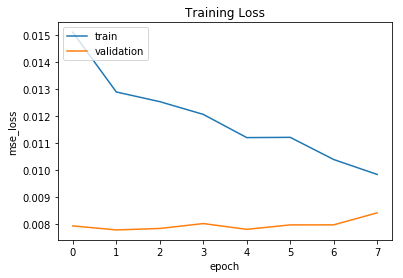

In [51]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Training Loss")
plt.ylabel("mse_loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc='upper left');

### Training looks better than previous

In [0]:
# import the best model
with open("./hourly_models/model_4/model.json", "r") as json_file:
    model_json = json_file.read()
best_model = model_from_json(model_json)
# load weights into the model
best_model.load_weights("./hourly_models/model_4/weights_best.hdf5")

In [64]:
predictions = []
print("Start: ", datetime.datetime.now())
for arr in X_eval:
    # here array shape is (n_input_timestemps, n_features)
    yhat = best_model.predict(arr.reshape(1, n_input, 8))
    predictions.append(yhat)
predictions = np.array(predictions)
print("End: ", datetime.datetime.now())

Start:  2019-10-08 09:17:25.665846
End:  2019-10-08 09:18:40.181235


In [65]:
# Prediction is also taking time
print(predictions.shape)
print(y_eval.shape)

(673, 1, 48, 1)
(673, 48)


### It took aproximately 75 seconds to give prediction for 673 instances.

In [0]:
scores = list()
# calculate an RMSE score for each hour
# make the prediction shape as eval shape
pred = predictions.reshape(predictions.shape[0], predictions.shape[2])
#  0th index of scalar values will have details about global_active_power
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
for i in range(y_eval.shape[1]):
    # convert to original scale, we have used MinMaxScalar
    y_eval_inverse = y_eval[:, i] * mult_range + add_min
    pred_inverse = pred[:, i] * mult_range + add_min
    # calculate mse
    mse = mean_squared_error(y_eval_inverse, pred_inverse)
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)

Text(0, 0.5, 'Prediction Hours')

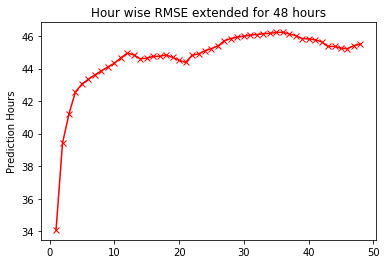

In [67]:
hours = np.arange(1,49)
plt.plot(hours, scores, marker='x', color="r")
plt.title("Hour wise RMSE extended for 48 hours")
plt.ylabel("RMSE global_active_power")
plt.ylabel("Prediction Hours")

In [68]:
# Checking overall RMSE
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
overall_mse = mean_squared_error(y_eval.flatten() * mult_range + add_min, pred.flatten() * mult_range + add_min)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 44.72


### Predictions for last 48 hours

In [69]:
X_pred, y_pred = X_test, y_test
print("Pred X shape: ", X_pred.shape)
print("Pred y shape (in reality it won't be there): ", y_pred.shape)

Pred X shape:  (1, 72, 8)
Pred y shape (in reality it won't be there):  (1, 48)


In [0]:
# predict for next 48 hours
predictions = []
# looping so that we can have multiple prediction instances
for arr in X_pred:
    # here array shape is (n_input_timestemps, n_features)
    yhat = best_model.predict(arr.reshape(1, n_input, 8))
    predictions.append(yhat)
predictions = np.array(predictions)

In [0]:
# Convert to original scale
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
# just looping so that we can generate multiple prediction instance
original_scale_pred = []
for p in predictions:
    inv_scale_pred = p.flatten() * mult_range + add_min
    original_scale_pred.append(inv_scale_pred)

In [0]:
# Create a dataframe to share this (any other way)
df = pd.DataFrame({"local_time": pd.date_range(start="2010-11-24 21:00:00", end="2010-11-26 20:00:00", freq="H"), 
                   "global_active_power": original_scale_pred[0]})
df.set_index("local_time", inplace=True)

In [73]:
df.head()

,global_active_power
local_time,
2010-11-24 21:00:00,117.712967
2010-11-24 22:00:00,78.179474
2010-11-24 23:00:00,46.239697
2010-11-25 00:00:00,29.862940
2010-11-25 01:00:00,24.423431


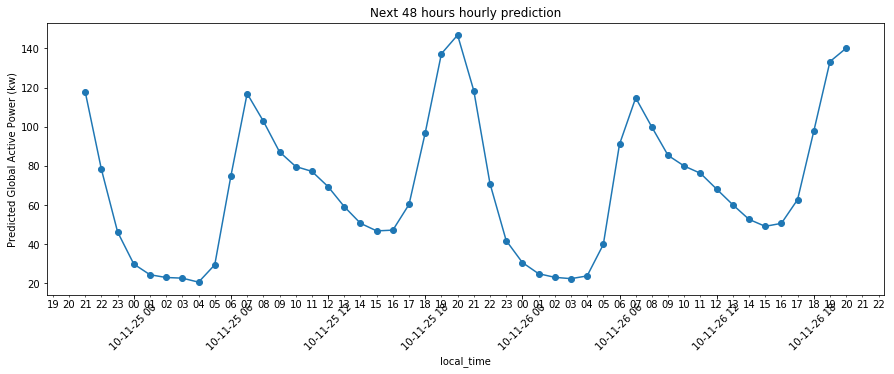

In [74]:
# Can share the visualtization also as a prediction results
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

### Compare Actual vs Predicted

In [0]:
df["actual_global_active_power"] = y_pred.flatten() * mult_range + add_min

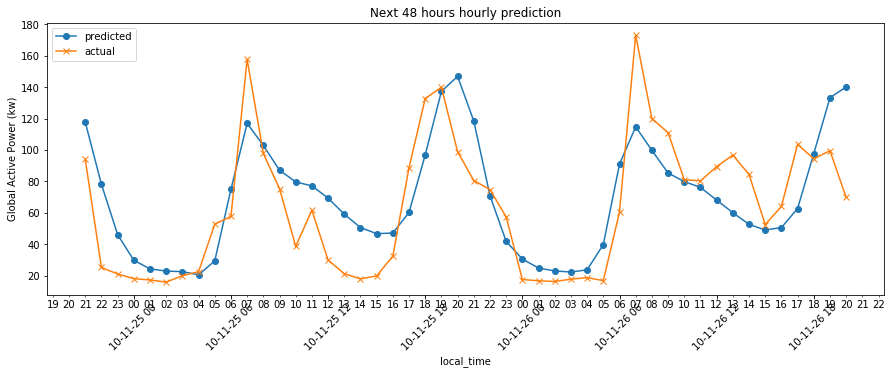

In [76]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.plot("actual_global_active_power", data=df, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);

### Compared to other univariate models we can see better results here. Still not very much better after adding 7 extra feature. Intuition is the other 7 extra features not helping much in getting a better model.

## Continue Training of the model by changing some parameters and checking if it improves further.

In [78]:
# model is already imported and loaded with best weights in above section
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               167200    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 48, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 200)           320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 48, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 48, 1)             101       
Total params: 508,201
Trainable params: 508,201
Non-trainable params: 0
_________________________________________________________________


In [90]:
# seeding the random number generation
seed = 101
np.random.seed(seed)
tf.set_random_seed(seed)
# defining parameters

# CHANGING LEARNING rate
learning_rate = 0.005
# because of CPU contraints, will run it for lesser number of epochs
epochs = 10
# bigger batch size
batch_size = 64
verbose = 2
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

# model is already loaded
best_model.load_weights("./hourly_models/model_4/weights_best.hdf5")

# create optimizer unit to define learning rate, this time no gradient clipping
optmzr = optimizers.Adam(lr=learning_rate, clipnorm=1.0)
# compile the model
best_model.compile(loss="mse", optimizer=optmzr,  metrics=["mse"])
tf.logging.set_verbosity(tf.logging.ERROR)

# model checkpoint
filepath="./hourly_models/model_4/weights_best_train_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=verbose, save_best_only=True, mode="min")
callbacks_list = [checkpoint]

start = datetime.datetime.now()
# Last time validation split was less, increasing (But here again by increasing we are reducing our training data)
best_model.fit(X_train, y_train, validation_split=0.15, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=verbose)
end = datetime.datetime.now()
print("Model training started at: ", start, " & ended at: ", end)

Train on 28522 samples, validate on 5034 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.00780, saving model to ./hourly_models/model_4/weights_best_train_2.hdf5
28522/28522 - 133s - loss: 6071.3004 - mean_squared_error: 6071.2930 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 2/10

Epoch 00002: val_loss improved from 0.00780 to 0.00778, saving model to ./hourly_models/model_4/weights_best_train_2.hdf5
28522/28522 - 130s - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 3/10

Epoch 00003: val_loss did not improve from 0.00778
28522/28522 - 128s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 4/10

Epoch 00004: val_loss did not improve from 0.00778
28522/28522 - 131s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 5/10

Epoch 00005: val_loss improved from 0.00778 to 0.00777, saving model to ./hourly_mo

In [0]:
# serialize weights to HDF5
best_model.save_weights("./hourly_models/model_4/last_weights_train_2.h5")

In [94]:
# removing 0th & 5th index because of high values
loss = model.history.history["loss"][1:]
loss.pop(4)
val_loss = model.history.history["val_loss"][1:]
val_loss.pop(4)

0.0076292199739445565

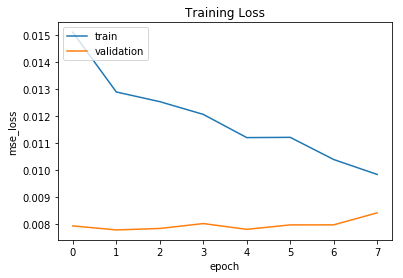

In [95]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Training Loss")
plt.ylabel("mse_loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc='upper left');

### Predicting with 10th epoch weights (last weights, instead of best weights).
**Thogh validation loss didn't improve in last epoch, training error was minimized and both the error looks closer. It can be a better generalization. We need to check both the models, with best weights and this last model. Considering we have validation data as 15 % of the data.**

In [96]:
predictions = []
print("Start: ", datetime.datetime.now())
for arr in X_eval:
    # here array shape is (n_input_timestemps, n_features)
    yhat = best_model.predict(arr.reshape(1, n_input, 8))
    predictions.append(yhat)
predictions = np.array(predictions)
print("End: ", datetime.datetime.now())

Start:  2019-10-08 10:35:01.557986
End:  2019-10-08 10:36:20.656626


In [0]:
scores = list()
# calculate an RMSE score for each hour
# make the prediction shape as eval shape
pred = predictions.reshape(predictions.shape[0], predictions.shape[2])
#  0th index of scalar values will have details about global_active_power
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
for i in range(y_eval.shape[1]):
    # convert to original scale, we have used MinMaxScalar
    y_eval_inverse = y_eval[:, i] * mult_range + add_min
    pred_inverse = pred[:, i] * mult_range + add_min
    # calculate mse
    mse = mean_squared_error(y_eval_inverse, pred_inverse)
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)

Text(0, 0.5, 'Prediction Hours')

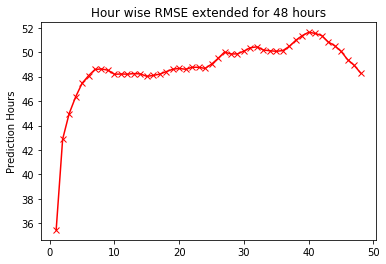

In [98]:
hours = np.arange(1,49)
plt.plot(hours, scores, marker='x', color="r")
plt.title("Hour wise RMSE extended for 48 hours")
plt.ylabel("RMSE global_active_power")
plt.ylabel("Prediction Hours")

In [99]:
# Checking overall RMSE
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
overall_mse = mean_squared_error(y_eval.flatten() * mult_range + add_min, pred.flatten() * mult_range + add_min)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 48.85


### Prediction for last 48 hours

In [100]:
X_pred, y_pred = X_test, y_test
print("Pred X shape: ", X_pred.shape)
print("Pred y shape (in reality it won't be there): ", y_pred.shape)

Pred X shape:  (1, 72, 8)
Pred y shape (in reality it won't be there):  (1, 48)


In [0]:
# predict for next 48 hours
predictions = []
# looping so that we can have multiple prediction instances
for arr in X_pred:
    # here array shape is (n_input_timestemps, n_features)
    yhat = best_model.predict(arr.reshape(1, n_input, 8))
    predictions.append(yhat)
predictions = np.array(predictions)

In [0]:
# Convert to original scale
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
# just looping so that we can generate multiple prediction instance
original_scale_pred = []
for p in predictions:
    inv_scale_pred = p.flatten() * mult_range + add_min
    original_scale_pred.append(inv_scale_pred)

In [0]:
# Create a dataframe to share this (any other way)
df = pd.DataFrame({"local_time": pd.date_range(start="2010-11-24 21:00:00", end="2010-11-26 20:00:00", freq="H"), 
                   "global_active_power": original_scale_pred[0]})
df.set_index("local_time", inplace=True)

In [104]:
df.head()

,global_active_power
local_time,
2010-11-24 21:00:00,134.116272
2010-11-24 22:00:00,89.268280
2010-11-24 23:00:00,44.047867
2010-11-25 00:00:00,26.121904
2010-11-25 01:00:00,24.519367


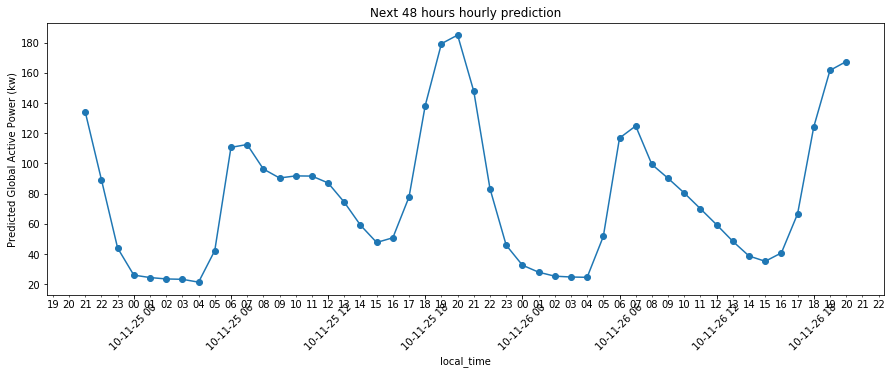

In [105]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

### Actual vs Prediction

In [0]:
df["actual_global_active_power"] = y_pred.flatten() * mult_range + add_min

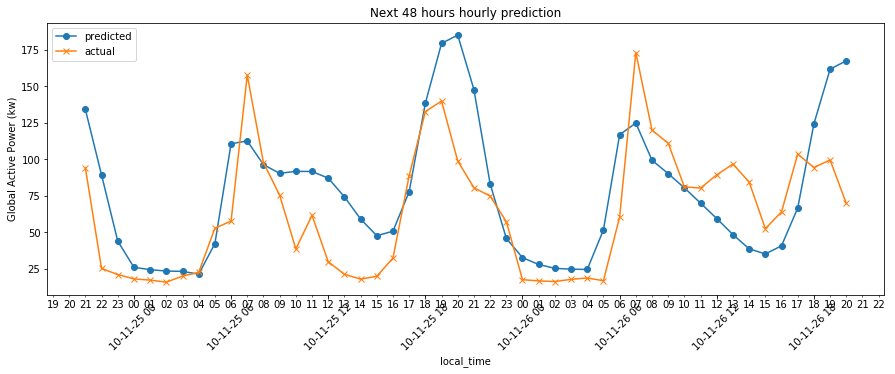

In [107]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.plot("actual_global_active_power", data=df, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);